# Combinatorial library vs. ChEMBL

## Aims of this notebook

In this notebook we want to compare the combinatorial library to the ChEMBL 25 dataset:

1. How similar are recombined ligands to ChEMBL ligands?
2. Which recombined ligands have exact matches in ChEMBL?

**Note** that the combinatorial library is stored as `json` file (6.7M molecules). The data needed for this notebook was extracted previously in notebook `4_1_combinatorial_library_data.ipynb` for easy and fast access here. In order to run this notebook, download data from https://osf.io/cy7tr/ and save files to `../data/combinatorial_library/`. 

## Table of contents

1. Most similar ChEMBL ligands
2. Exact matches  
  2.1. Get exact matches  
  2.2. Get ChEMBL clients and set up filtering documentation  
  2.3. Get molecules from ChEMBL (by InChI key)  
  2.4. Get molecules with human targets in ChEMBL  
  2.5. Check molecule/target/assay/bioactivity distributions  
  2.6. Get active molecules (among the exact matches)  
  2.7. Get target metadata (PTC) for active molecules  
  2.8. Results  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from chembl_webresource_client.new_client import new_client
import ijson
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole

from utils import read_fragment_library, construct_ligand, get_protein_target_classifications

In [3]:
ACTIVITY_THRESHOLD = 500

## 1. Most similar ChEMBL ligands

In [4]:
chembl_most_similar = pd.read_json('../data/combinatorial_library/chembl_most_similar.json')
chembl_most_similar.head()

,chembl_id,similarity
0,CHEMBL4089123,0.52
1,CHEMBL3641905,0.61
2,CHEMBL3355540,0.63
3,CHEMBL149168,0.57
4,CHEMBL3759442,0.65


How many ligands have highly similar fingerprints in ChEMBL vs. combinatorial library? 

Note that values have been rounded to two decimals, i.e. `1.0` does not automatically mean that these ligands are identical.

In [5]:
chembl_most_similar[chembl_most_similar.similarity == 1.0].shape

(247, 2)

Check: Are these ligands part of the exact matches?

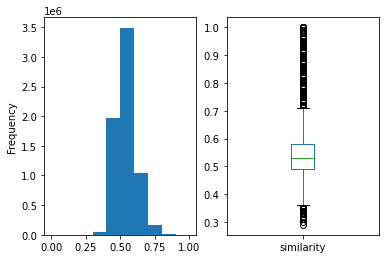

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2) 
bins = np.arange(0, 1.1, 0.1)
chembl_most_similar.similarity.plot(kind='hist', bins=bins, ax=axes[0])
chembl_most_similar.similarity.plot(kind='box', ax=axes[1])

## 2. Exact matches

### 2.1. Get exact matches

In [7]:
exact_matches = pd.read_json('../data/combinatorial_library/chembl_exact.json')

In [8]:
print(exact_matches.shape[0])
exact_matches.head()

298


,bond_ids,fragment_ids,hba,hbd,mwt,logp,n_atoms,chembl_exact,chembl_most_similar,original_exact,original_substructure,inchi
0,"[[GA_10, B1_7], [GA_9, AP_11], [AP_12, SE_13]]","[B1_19, GA_35, AP_6, SE_1]",1,1,0,0,40,1,"[CHEMBL2347516, 1.0]",0,0,InChI=1S/C32H28ClFN4O2/c33-29-18-27(9-11-31(29...
1,"[[SE_8, AP_8], [FP_6, AP_9]]","[AP_99, SE_16, FP_25]",1,1,1,1,22,1,"[CHEMBL265923, 1.0]",0,0,InChI=1S/C16H13N3O2S/c1-21-13-6-4-12(5-7-13)18...
2,"[[FP_6, AP_9], [AP_8, SE_6]]","[AP_99, FP_103, SE_138]",1,1,1,1,20,1,"[CHEMBL1446166, 0.9400000000000001]",0,0,InChI=1S/C16H12N2OS/c19-15(17-13-9-5-2-6-10-13...
3,"[[AP_8, SE_7], [FP_6, AP_9]]","[AP_99, FP_103, SE_38]",1,1,1,1,21,1,"[CHEMBL1446166, 1.0]",0,0,InChI=1S/C16H11ClN2OS/c17-12-6-8-13(9-7-12)18-...
4,"[[GA_10, B1_7], [GA_9, AP_11], [AP_12, SE_14]]","[GA_35, SE_2, AP_6, B1_19]",1,1,0,0,41,1,"[CHEMBL2347518, 1.0]",0,0,InChI=1S/C32H26ClFN4O3/c33-28-18-26(9-11-30(28...


In [9]:
exact_matches.drop_duplicates('inchi', inplace=True)
exact_matches.shape[0]

298

#### Compare exact matches with similarity calculation

In theory, the exact matches should have a similarity of 1.0. 

Procedure for calculating (i) exact matches and (ii) similarities.
- (i) Recombined ligands are constructed as `ROMol`, standardized, `ROMol` > `InChI` (InChI as basis for comparison)
- (ii) Recombined ligands are constructed as `ROMol`, standardized and directly used for fingerprint generation.

How many exact matches have a similarity != 1.0?

In [10]:
exact_matches[exact_matches.chembl_most_similar.apply(lambda x: x[1] != 1.0)].shape

(100, 12)

Show similarity distribution of exact matches.

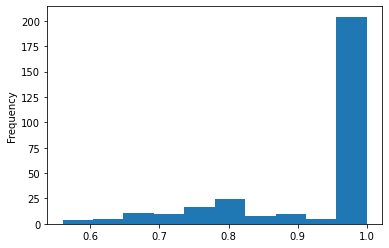

In [11]:
exact_matches.chembl_most_similar.apply(lambda x: x[1]).plot(kind='hist')

In [12]:
exact_matches[exact_matches.chembl_most_similar.apply(lambda x: x[1] != 1.0)].head()

,bond_ids,fragment_ids,hba,hbd,mwt,logp,n_atoms,chembl_exact,chembl_most_similar,original_exact,original_substructure,inchi
2,"[[FP_6, AP_9], [AP_8, SE_6]]","[AP_99, FP_103, SE_138]",1,1,1,1,20,1,"[CHEMBL1446166, 0.9400000000000001]",0,0,InChI=1S/C16H12N2OS/c19-15(17-13-9-5-2-6-10-13...
5,"[[FP_6, AP_9], [SE_15, AP_8]]","[AP_99, SE_9, FP_25]",1,1,1,1,29,1,"[CHEMBL254546, 0.87]",0,0,InChI=1S/C21H23N5O2S/c1-25-8-10-26(11-9-25)16-...
6,"[[FP_6, AP_9], [SE_3, AP_8]]","[AP_99, FP_103, SE_74]",1,1,1,1,17,1,"[CHEMBL4070122, 0.79]",0,0,InChI=1S/C13H12N2OS/c1-2-8-14-12(16)11-9-17-13...
8,"[[FP_10, AP_8], [SE_10, AP_9]]","[AP_95, SE_22, FP_14]",1,1,1,1,28,1,"[CHEMBL2203552, 0.71]",1,1,InChI=1S/C21H17N5O2/c1-28-18-11-24-20(13-8-12-...
10,"[[SE_12, AP_8], [FP_6, AP_9]]","[AP_99, FP_103, SE_15]",1,1,1,1,26,1,"[CHEMBL265923, 0.8200000000000001]",0,0,InChI=1S/C19H18N2O4S/c1-23-15-9-13(10-16(24-2)...


In [13]:
exact_matches.loc[2, 'inchi']

'InChI=1S/C16H12N2OS/c19-15(17-13-9-5-2-6-10-13)14-11-20-16(18-14)12-7-3-1-4-8-12/h1-11H,(H,17,19)'

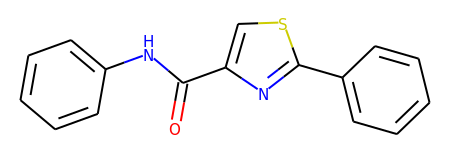

In [14]:
fragment_library = read_fragment_library(Path('../data/fragment_library_reduced/'))
construct_ligand(
    exact_matches.loc[2, 'fragment_ids'], 
    exact_matches.loc[2, 'bond_ids'],
    fragment_library
)

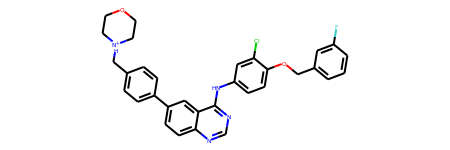

In [15]:
fragment_library = read_fragment_library(Path('../data/fragment_library_reduced/'))
construct_ligand(
    exact_matches.loc[0, 'fragment_ids'], 
    exact_matches.loc[0, 'bond_ids'],
    fragment_library
)

### 2.2. Remove original ligands (exact and substructure matches)

In [16]:
original_ligand_matches = pd.concat(
    [
        pd.read_json('../data/combinatorial_library/original_exact.json'),
        pd.read_json('../data/combinatorial_library/original_substructure.json')
    ]
)
original_ligand_matches.shape

(359, 12)

In [17]:
exact_matches = exact_matches[
    ~exact_matches.apply(lambda x: x.inchi in original_ligand_matches.inchi.to_list(), axis=1)
]

In [18]:
print(f'Number of exact ChEMBL matches without original ligands: {exact_matches.shape[0]}')

Number of exact ChEMBL matches without original ligands: 218


### 2.2. Get ChEMBL clients and set up filtering documentation

In [19]:
similarity_client = new_client.similarity
molecule_client = new_client.molecule
activity_client = new_client.activity
target_client = new_client.target

In [20]:
def add_filtering_step(filtering, df, step_name):
    
    return filtering.append(
        pd.Series(
            [
                step_name,
                len(df.molecule_chembl_id.unique()),
                len(df.target_chembl_id.unique()),
                len(df.assay_chembl_id.unique()),
                df.shape[0]
            ],
            index=['filtering_step', 'molecules', 'targets', 'assays', 'activities']
        ),
        ignore_index=True
    )

In [21]:
# Initialize filtering table
filtering = pd.DataFrame(columns=['filtering_step', 'molecules', 'targets', 'assays', 'activities'])

### 2.3. Get molecules from ChEMBL (by InChI key)

- Get molecule data from ChEMBL
- Approved molecules?
- ATC classified molecules?

#### Get molecule data from ChEMBL

In [22]:
# Get InChI keys (will be queries for ChEMBL)
exact_matches['inchi_key'] = exact_matches.inchi.apply(lambda x: Chem.InchiToInchiKey(x))

In [23]:
def get_molecules(inchi_keys):
    
    result = [molecule_client.get(inchi_key) for inchi_key in inchi_keys]
    
    molecules = pd.DataFrame(result)
    molecules = molecules[['molecule_chembl_id', 'molecule_structures', 'first_approval', 'atc_classifications', 'indication_class', 'pref_name']]
    molecules['smiles'] = molecules.molecule_structures.apply(lambda x: x['canonical_smiles'])
    molecules['inchi'] = molecules.molecule_structures.apply(lambda x: x['standard_inchi'])
    molecules.drop('molecule_structures', axis=1, inplace=True)
    PandasTools.AddMoleculeColumnToFrame(molecules, 'smiles')
    
    print(f'Number of queries: {len(inchi_keys)}')
    print(f'Number of query results: {molecules.shape[0]}')
    
    return molecules

In [24]:
molecules = get_molecules(exact_matches.inchi_key)

Number of queries: 218
Number of query results: 218


#### Approved molecules?

,molecule_chembl_id,first_approval,atc_classifications,indication_class,pref_name,smiles,inchi,ROMol
191,CHEMBL64,1952.0,"[J04AC51, J04AC01]",Antibacterial (tuberculostatic),ISONIAZID,NNC(=O)c1ccncc1,InChI=1S/C6H7N3O/c7-9-6(10)5-1-3-8-4-2-5/h1-4H...,

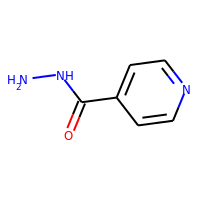

In [25]:
# Check if first_approval field is not empty
molecules[~molecules.first_approval.isna()]

**`CHEMBL64`, Isoniazid**

- [ChEMBL compound report card](https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL64/)
- [Drugbank](https://www.drugbank.ca/drugs/DB00951)
  > **Description**: Antibacterial agent used primarily as a tuberculostatic. It remains the treatment of choice for tuberculosis. </br>
  > **Mechanism of action**: Isoniazid is a prodrug and must be activated by bacterial catalase. Specficially, activation is associated with reduction of the mycobacterial ferric **KatG catalase-peroxidase** by hydrazine and reaction with oxygen to form an oxyferrous enzyme complex. Once activated, isoniazid inhibits the synthesis of mycoloic acids, an essential component of the bacterial cell wall. At therapeutic levels isoniazid is bacteriocidal against actively growing intracellular and extracellular *Mycobacterium tuberculosis* organisms. Specifically isoniazid inhibits **InhA, the enoyl reductase** from *Mycobacterium tuberculosis*, by forming a covalent adduct with the NAD cofactor. It is the INH-NAD adduct that acts as a slow, tight-binding competitive inhibitor of InhA. </br>
  > **Target**: Catalase-peroxidase (UniProt ID [P9WIE5](https://www.uniprot.org/uniprot/P9WIE5))
  
- Off-targets? Kinases?
  - Cytochrome P450 2E1 and Arylamine N-acetyltranserases are associated with isoniazid side effects ([DrugBank's "Pharmacogenomic Effects/ADRs"](https://www.drugbank.ca/drugs/DB00951)).
  - [SwissTargetPredictions](http://swisstargetprediction.ch/result.php?job=1698711713&organism=Homo_sapiens) (ligand-based target prediction) predicts a few kinases in the top 15 off-targets.
  - [ProBis](http://probis.cmm.ki.si/browse.php?job_id=2cca.A) (structure-based target prediction for [2CCA](https://www.rcsb.org/structure/2cca)) predicts mainly peroxidases (no kinases).

#### ATC classified molecules?

> In the Anatomical Therapeutic Chemical (ATC) classification system, the active substances are divided into different groups according to the organ or system on which they act and their therapeutic, pharmacological and chemical properties.
Drugs are classified in groups at five different levels.

https://www.who.int/medicines/regulation/medicines-safety/toolkit_atc/en/

In [26]:
# Check if atc classified field is not empty
molecules[molecules.atc_classifications.str.len() != 0].drop('ROMol', axis=1)

,molecule_chembl_id,first_approval,atc_classifications,indication_class,pref_name,smiles,inchi
191,CHEMBL64,1952.0,"[J04AC51, J04AC01]",Antibacterial (tuberculostatic),ISONIAZID,NNC(=O)c1ccncc1,InChI=1S/C6H7N3O/c7-9-6(10)5-1-3-8-4-2-5/h1-4H...


Same as retrieved via the approved molecules query.

### 2.4. Get molecules with human targets in ChEMBL

- Get activities (by molecule ChEMBL IDs)
- Remove activities for non-human target origanisms

#### Get activities (by molecule ChEMBL IDs)

In [27]:
def get_activities(molecule_ids):
    
    activities = activity_client.filter(
        molecule_chembl_id__in=molecule_ids,
        type='IC50', 
        relation='=', 
        assay_type='B'
    ).only(
        'activity_id','assay_chembl_id', 'assay_description', 'assay_type', \
        'molecule_chembl_id', 'type', 'standard_units', 'relation', 'standard_value', \
        'target_chembl_id', 'target_organism', 'target_pref_name'
    )
    
    activities_df = pd.DataFrame.from_records(list(activities))
    activities_df = activities_df.astype({'standard_value': 'float'})
    
    print(f'Number of queries: {len(molecule_ids)}')
    print(f'Number of query results: {activities_df.shape[0]}')
    
    return activities_df

In [28]:
activities = get_activities(list(molecules.molecule_chembl_id))

Number of queries: 218
Number of query results: 207


In [29]:
activities[activities.molecule_chembl_id == 'CHEMBL64']

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,target_pref_name,type,units,value
163,16843814,CHEMBL3877133,Irreversible inhibition of MPO (unknown origin),B,CHEMBL64,=,nM,5000.0,CHEMBL2439,Homo sapiens,Myeloperoxidase,IC50,uM,5.0
164,16843827,CHEMBL3877132,Inhibition of human MPO,B,CHEMBL64,=,nM,4700.0,CHEMBL2439,Homo sapiens,Myeloperoxidase,IC50,uM,4.7


In [30]:
activities.columns

Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'standard_units', 'standard_value',
       'target_chembl_id', 'target_organism', 'target_pref_name', 'type',
       'units', 'value'],
      dtype='object')

In [31]:
filtering = add_filtering_step(filtering, activities, 'ChEMBL bioactivity entries')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,99,77,122,207


**Important**: Check if all standard units are really nM.

In [32]:
activities.groupby(
    ['standard_units']
).size()

standard_units
nM    207
dtype: int64

In [33]:
# Just to be sure, drop all entries with standard unit other than nM 
# Note: One could also perform a unit conversion here
activities.drop(
    index=activities[activities.standard_units != 'nM'].index,
    inplace=True
)

In [34]:
filtering = add_filtering_step(filtering, activities, 'Remove non-nM activities')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,99,77,122,207
1,Remove non-nM activities,99,77,122,207


#### Remove activities for non-human target organisms

In [35]:
activities.groupby('target_organism').size()

target_organism
Agaricus bisporus                   1
Bos taurus                          2
Escherichia coli K-12               1
Homo sapiens                      179
Human immunodeficiency virus 1      1
Mus musculus                        3
Ovis aries                          2
Photinus pyralis                    3
Photuris pennsylvanica              3
Rattus norvegicus                   1
dtype: int64

In [36]:
activities = activities[activities.target_organism == 'Homo sapiens'].copy()
activities.drop('target_organism', axis=1, inplace=True)

In [37]:
filtering = add_filtering_step(filtering, activities, 'Only human entries')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,99,77,122,207
1,Remove non-nM activities,99,77,122,207
2,Only human entries,87,66,106,179


### 2.5. Check molecule/target/assay/bioactivity distributions

#### How many targets are reported per molecule?

In [38]:
n_targets_per_molecule = activities.groupby(
    ['molecule_chembl_id']
)['target_chembl_id'].size()

n_targets_per_molecule.value_counts(sort=False)

1     52
2     15
3      7
4      6
5      2
6      1
8      2
10     2
Name: target_chembl_id, dtype: int64

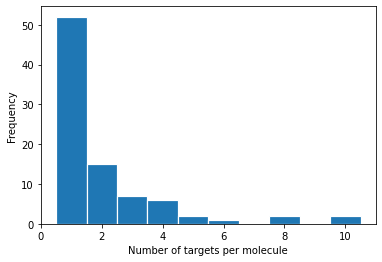

In [39]:
ax = n_targets_per_molecule.plot(
    kind='hist', 
    bins=np.arange(n_targets_per_molecule.max() + 2) - 0.5, 
    edgecolor='white', 
    linewidth=1.2,
    xlim=[0, n_targets_per_molecule.max() + 1]
)
ax.set_xlabel('Number of targets per molecule')
plt.show()

#### How many different assays were used to measure molecule-target activities?

In [40]:
n_assays_per_molecule_target = activities.groupby(
    ['molecule_chembl_id', 'target_chembl_id']
)['assay_chembl_id'].size()

n_assays_per_molecule_target.value_counts(sort=False)

1    131
2     15
3      2
4      3
Name: assay_chembl_id, dtype: int64

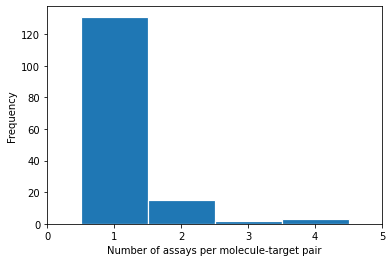

In [41]:
ax = n_assays_per_molecule_target.plot(
    kind='hist', 
    bins=np.arange(n_assays_per_molecule_target.max() + 2) - 0.5, 
    edgecolor='white', 
    linewidth=1.2,
    xlim=[0, n_assays_per_molecule_target.max() + 1]
)
ax.set_xlabel('Number of assays per molecule-target pair')
plt.show()

#### Look at all activities measured per molecule-target-assay combination

Get all activities for each molecule-target-assay combination.

In [42]:
activities_per_molecule_target_assay = activities.groupby(
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'assay_chembl_id', 'assay_description']
)['standard_value'].apply(list).reset_index()

Show examples.

In [43]:
activities_per_molecule_target_assay.head()

,molecule_chembl_id,target_chembl_id,target_pref_name,assay_chembl_id,assay_description,standard_value
0,CHEMBL1082236,CHEMBL262,Glycogen synthase kinase-3 beta,CHEMBL1113275,Inhibition of human recombinant GSK3-beta usin...,[27.0]
1,CHEMBL1086175,CHEMBL262,Glycogen synthase kinase-3 beta,CHEMBL1113275,Inhibition of human recombinant GSK3-beta usin...,[1353.0]
2,CHEMBL1086638,CHEMBL262,Glycogen synthase kinase-3 beta,CHEMBL1113275,Inhibition of human recombinant GSK3-beta usin...,[76.0]
3,CHEMBL1086640,CHEMBL262,Glycogen synthase kinase-3 beta,CHEMBL1113275,Inhibition of human recombinant GSK3-beta usin...,[195.0]
4,CHEMBL1086782,CHEMBL262,Glycogen synthase kinase-3 beta,CHEMBL1113275,Inhibition of human recombinant GSK3-beta usin...,[661.0]


Get all activities for each molecule-target combination.

In [44]:
activities_per_molecule_target = activities_per_molecule_target_assay.groupby(
    ['molecule_chembl_id', 'target_chembl_id']
)['standard_value'].apply(list).reset_index()

Get molecule-target pairs that have multiple activities from either multiple assays or a single assay.

In [45]:
activities_per_molecule_target[
    (activities_per_molecule_target.standard_value.apply(len) > 1) | (activities_per_molecule_target.standard_value.apply(len)[0] > 1)
].reset_index()

,index,molecule_chembl_id,target_chembl_id,standard_value
0,31,CHEMBL1652706,CHEMBL3629,"[[4.0, 7.0], [2325.0]]"
1,33,CHEMBL2030386,CHEMBL2147,"[[13.0], [5.0]]"
2,38,CHEMBL2030386,CHEMBL5443,"[[5.5], [1805.0]]"
3,84,CHEMBL3341791,CHEMBL4439,"[[21000.0], [4300.0]]"
4,86,CHEMBL3341948,CHEMBL4439,"[[12300.0], [3800.0]]"
5,94,CHEMBL3409588,CHEMBL4040,"[[3.9], [3.9]]"
6,98,CHEMBL3680991,CHEMBL5247,"[[1600.0], [1600.0]]"
7,99,CHEMBL3681001,CHEMBL5247,"[[900.0], [900.0]]"
8,100,CHEMBL3700409,CHEMBL3629,"[[113.0, 200.0], [19870.0]]"
9,102,CHEMBL3754304,CHEMBL6166,"[[64.0], [4200.0]]"


### 2.6. Get active molecules (among the exact matches)

- Get highest activity (lowest IC50) per molecule-target pair
- Get molecules that are "active" (<=`ACTIVITY_THRESHOLD` nM) against at least one target

#### Get highest activity (lowest IC50) per molecule-target pair

Get lowest IC50 value per molecule-target pair by (i) sorting the DataFrame by molecule ChEMBL ID, target ChEMBL ID and activity value (ascending), (ii) group activites by molecule-target pairs, and (iii) take the first activity value (i.e. the minimum value because of step (ii)) per molecule-target pair (i.e. per group).

In [46]:
activities_min = activities.sort_values(
    ['molecule_chembl_id', 'target_chembl_id', 'standard_value']
).groupby(
    ['molecule_chembl_id', 'target_chembl_id']
).first().reset_index()

In [47]:
filtering = add_filtering_step(filtering, activities_min, 'Get minimum IC50 per molecule-target pair')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,99,77,122,207
1,Remove non-nM activities,99,77,122,207
2,Only human entries,87,66,106,179
3,Get minimum IC50 per molecule-target pair,87,66,90,151


#### Get molecules that are "active" (<=`ACTIVITY_THRESHOLD` nM) against at least one target

In [48]:
activities_active = activities_min[activities_min.standard_value <= ACTIVITY_THRESHOLD]
activities_active.head()

,molecule_chembl_id,target_chembl_id,activity_id,assay_chembl_id,assay_description,assay_type,relation,standard_units,standard_value,target_pref_name,type,units,value
0,CHEMBL1082236,CHEMBL262,3186376,CHEMBL1113275,Inhibition of human recombinant GSK3-beta usin...,B,=,nM,27.0,Glycogen synthase kinase-3 beta,IC50,uM,0.027
2,CHEMBL1086638,CHEMBL262,3186379,CHEMBL1113275,Inhibition of human recombinant GSK3-beta usin...,B,=,nM,76.0,Glycogen synthase kinase-3 beta,IC50,uM,0.076
3,CHEMBL1086640,CHEMBL262,3186381,CHEMBL1113275,Inhibition of human recombinant GSK3-beta usin...,B,=,nM,195.0,Glycogen synthase kinase-3 beta,IC50,uM,0.195
12,CHEMBL1269663,CHEMBL279,3521784,CHEMBL1273328,Inhibition of VEGFR2,B,=,nM,107.2,Vascular endothelial growth factor receptor 2,IC50,nM,107.2
13,CHEMBL1287863,CHEMBL4630,3603342,CHEMBL1291622,Inhibition of His-tagged CHK1 after 2 hrs by l...,B,=,nM,2.0,Serine/threonine-protein kinase Chk1,IC50,nM,2.0


In [49]:
filtering = add_filtering_step(filtering, activities_active, 'Only "active" molecule-target pairs')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,99,77,122,207
1,Remove non-nM activities,99,77,122,207
2,Only human entries,87,66,106,179
3,Get minimum IC50 per molecule-target pair,87,66,90,151
4,"Only ""active"" molecule-target pairs",47,32,45,76


In [50]:
np.arange(0, 501, 50)

array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500])

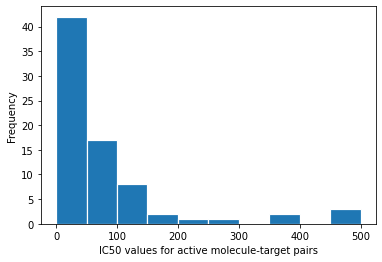

In [51]:
ax = activities_active.standard_value.plot(
    kind='hist', 
    bins=np.arange(0, 501, 50), 
    edgecolor='white', 
    linewidth=1.2
)
ax.set_xlabel('IC50 values for active molecule-target pairs')
plt.show()

### 2.7. Get target metadata (PTC) for active molecules

- Get ChEMBL target details: Protein target classification (PTC)
- Show enzyme group distribution for unique target ChEMBL IDs
- Combine molecule, bioactivity, and target information

#### Get ChEMBL target details: Protein target classification (PTC)

In order to access the protein target classification, we follow the instructions given here: https://github.com/chembl/chembl_webservices_2/issues/95

In [52]:
target_chembl_ids = list(activities_active.target_chembl_id.unique())
print(f'Number of unique targets (target ChEMBL IDs): {len(target_chembl_ids)}')

Number of unique targets (target ChEMBL IDs): 32


Get PTC for target ChEMBL IDs.

In [53]:
# Takes a up to a minute
protein_target_classifications = get_protein_target_classifications(target_chembl_ids)
print(f'Number of PTCs (multiple PTCs per target possible): {protein_target_classifications.shape[0]}')

Number of PTCs (multiple PTCs per target possible): 39


In [54]:
protein_target_classifications.head()

,target_chembl_id,l1,l2,l3,l4,l5,l6,l7,l8,protein_class_id,component_id,protein_classification_id
0,CHEMBL262,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,CMGC protein kinase GSK family,None,None,None,239,3114,239
1,CHEMBL279,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase VEGFR family,None,None,None,160,359,160
2,CHEMBL4630,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase CAMK1 family,CAMK protein kinase CHK1 subfamily,None,None,411,2947,411
3,CHEMBL1907601,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,None,None,None,None,148,17,148
4,CHEMBL1907601,Other cytosolic protein,None,None,None,None,None,None,None,8,34,8


Show targets with multiple PTCs.

In [55]:
n_ptc_per_target = protein_target_classifications.groupby('target_chembl_id').size()
protein_target_classifications[protein_target_classifications.target_chembl_id.isin(n_ptc_per_target[n_ptc_per_target > 1].index)]

,target_chembl_id,l1,l2,l3,l4,l5,l6,l7,l8,protein_class_id,component_id,protein_classification_id
3,CHEMBL1907601,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,None,None,None,None,148,17,148
4,CHEMBL1907601,Other cytosolic protein,None,None,None,None,None,None,None,8,34,8
6,CHEMBL2095191,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,129,699,129
7,CHEMBL2095191,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252,1946,252
8,CHEMBL2095191,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252,2389,252
11,CHEMBL3038477,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,129,699,129
12,CHEMBL3038477,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252,1946,252
13,CHEMBL3883328,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,129,699,129
14,CHEMBL3883328,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252,2389,252
27,CHEMBL2971,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakA family,None,None,None,152,1302,152


Select per target the PTC that has the least `None` values (if the same number of `None`, select first entry).

In [56]:
group_representatives = []

for name, group in protein_target_classifications.groupby('target_chembl_id', sort=False):
    
    if len(group) == 1:
        group_representatives.append(group)
    else:
        ix_least_none = group['l1 l2 l3 l4 l5 l6 l7 l8'.split()].isna().sum(axis=1).idxmin()
        group_representatives.append(group.loc[[ix_least_none]])
        
protein_target_classifications = pd.concat(group_representatives)
print(f'Number of PTCs (after deduplicating PTCs per target): {protein_target_classifications.shape[0]}')

Number of PTCs (after deduplicating PTCs per target): 32


#### Show enzyme group distribution for unique target ChEMBL IDs

In [57]:
protein_target_classifications.groupby(by='l2').size()

l2
Cytochrome P450               1
Kinase                       30
Voltage-gated ion channel     1
dtype: int64

#### Combine molecule, bioactivity, and target information

Merge bioactivities and PTC information on target ChEMBL IDs.

In [58]:
activities_active = pd.merge(
    activities_active, protein_target_classifications, on='target_chembl_id', how='left'
).sort_values(
    by=['molecule_chembl_id', 'standard_value']
)[['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'assay_chembl_id', 'assay_description', 'standard_value']]

activities_active.fillna('Unknown', inplace=True)

print(activities_active.shape)
activities_active.head()

(76, 12)


,molecule_chembl_id,target_chembl_id,target_pref_name,l1,l2,l3,l4,l5,l6,assay_chembl_id,assay_description,standard_value
0,CHEMBL1082236,CHEMBL262,Glycogen synthase kinase-3 beta,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,CMGC protein kinase GSK family,Unknown,CHEMBL1113275,Inhibition of human recombinant GSK3-beta usin...,27.0
1,CHEMBL1086638,CHEMBL262,Glycogen synthase kinase-3 beta,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,CMGC protein kinase GSK family,Unknown,CHEMBL1113275,Inhibition of human recombinant GSK3-beta usin...,76.0
2,CHEMBL1086640,CHEMBL262,Glycogen synthase kinase-3 beta,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,CMGC protein kinase GSK family,Unknown,CHEMBL1113275,Inhibition of human recombinant GSK3-beta usin...,195.0
3,CHEMBL1269663,CHEMBL279,Vascular endothelial growth factor receptor 2,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase VEGFR family,Unknown,CHEMBL1273328,Inhibition of VEGFR2,107.2
4,CHEMBL1287863,CHEMBL4630,Serine/threonine-protein kinase Chk1,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase CAMK1 family,CAMK protein kinase CHK1 subfamily,CHEMBL1291622,Inhibition of His-tagged CHK1 after 2 hrs by l...,2.0


### 2.8. Results

- Number of targets per molecule
- Targets per molecule
- Molecules without kinase target(s)
- Molecules with kinase target(s)
- Molecules with kinase target(s) with activity of <= 5 nM

`activities_active` contains information for each ChEMBL molecule-target combination.

#### Number of targets per molecule

In [59]:
n_active_targets_per_molecule = activities_active.groupby(['molecule_chembl_id'])['target_chembl_id'].size()

n_active_targets_per_molecule.value_counts(sort=False)

1    40
2     3
6     1
8     3
Name: target_chembl_id, dtype: int64

Text(0.5, 0, 'Number of targets per molecule')

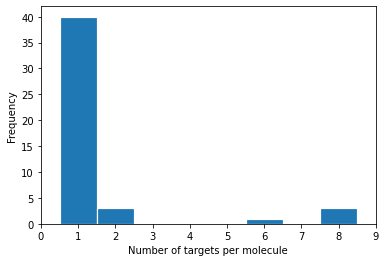

In [60]:
ax = n_active_targets_per_molecule.plot(
    kind='hist', 
    bins=np.arange(n_active_targets_per_molecule.max() + 2) - 0.5, 
    edgecolor='white', 
    linewidth=1.2,
    xlim=[0, n_active_targets_per_molecule.max() + 1]
)
ax.set_xlabel('Number of targets per molecule')

#### Targets per molecule

In [61]:
pd.set_option("display.max_rows", 100)
pd.set_option('max_colwidth', 200)

In [62]:
molecules_with_targets = pd.DataFrame(
    [
        activities_active.groupby(['molecule_chembl_id'])['l2'].apply(list),
        activities_active.groupby(['molecule_chembl_id'])['target_pref_name'].apply(list),
        activities_active.groupby(['molecule_chembl_id'])['target_chembl_id'].apply(list),
        activities_active.groupby(['molecule_chembl_id'])['standard_value'].apply(list),
    ]
).transpose()

print(f'Number of molecules with human targets that have activity <= {ACTIVITY_THRESHOLD}: {molecules_with_targets.shape[0]}')

Number of molecules with human targets that have activity <= 500: 47


In [63]:
# Add molecule name
molecules_with_targets = pd.merge(
    molecules_with_targets, molecules[['molecule_chembl_id', 'pref_name']], on='molecule_chembl_id', how='left'
)

In [64]:
molecules_with_targets

,molecule_chembl_id,l2,target_pref_name,target_chembl_id,standard_value,pref_name
0,CHEMBL1082236,[Kinase],[Glycogen synthase kinase-3 beta],[CHEMBL262],[27.0],None
1,CHEMBL1086638,[Kinase],[Glycogen synthase kinase-3 beta],[CHEMBL262],[76.0],None
2,CHEMBL1086640,[Kinase],[Glycogen synthase kinase-3 beta],[CHEMBL262],[195.0],None
3,CHEMBL1269663,[Kinase],[Vascular endothelial growth factor receptor 2],[CHEMBL279],[107.2],None
4,CHEMBL1287863,[Kinase],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[2.0],None
5,CHEMBL1288009,[Kinase],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[3.0],None
6,CHEMBL1288251,[Kinase],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[34.0],None
7,CHEMBL1288278,[Kinase],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[1.0],None
8,CHEMBL147281,[Kinase],[Cyclin-dependent kinase 4/cyclin D1],[CHEMBL1907601],[460.0],None
9,CHEMBL1645408,[Cytochrome P450],[Cytochrome P450 11B2],[CHEMBL2722],[65.0],None


#### Molecules without kinase target(s)

In [65]:
molecules_with_targets[~molecules_with_targets.l2.apply(lambda x: 'Kinase' in x)]

,molecule_chembl_id,l2,target_pref_name,target_chembl_id,standard_value,pref_name
9,CHEMBL1645408,[Cytochrome P450],[Cytochrome P450 11B2],[CHEMBL2722],[65.0],None
10,CHEMBL1645409,[Cytochrome P450],[Cytochrome P450 11B2],[CHEMBL2722],[104.0],None
40,CHEMBL4095993,[Voltage-gated ion channel],[Transient receptor potential cation channel subfamily A member 1],[CHEMBL6007],[42.0],None


#### Molecules with kinase target(s)

Keep only molecule-target pairs where target=kinase.

In [66]:
activities_active_kinases = activities_active[
    activities_active.l2 == 'Kinase'
]

In [67]:
filtering = add_filtering_step(filtering, activities_active_kinases, 'Only molecule-kinase pairs')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,99,77,122,207
1,Remove non-nM activities,99,77,122,207
2,Only human entries,87,66,106,179
3,Get minimum IC50 per molecule-target pair,87,66,90,151
4,"Only ""active"" molecule-target pairs",47,32,45,76
5,Only molecule-kinase pairs,44,30,43,73


Across all molecule-target pairs count kinase groups.

In [68]:
activities_active_kinases.l4.apply(lambda x: x.split()[0]).value_counts()

TKL        25
CAMK       12
Other      11
CMGC       11
TK          9
Unknown     3
STE         1
AGC         1
Name: l4, dtype: int64

Summarize target information per molecule (`molecules_with_kinase_targets`).

In [69]:
molecules_with_kinase_targets = pd.DataFrame(
    [
        activities_active_kinases.groupby(['molecule_chembl_id'])['l4'].apply(list),
        activities_active_kinases.groupby(['molecule_chembl_id'])['target_pref_name'].apply(list),
        activities_active_kinases.groupby(['molecule_chembl_id'])['target_chembl_id'].apply(list),
        activities_active_kinases.groupby(['molecule_chembl_id'])['standard_value'].apply(list),
    ]
).transpose()
print(f'Number of molecules with kinase target(s): {molecules_with_kinase_targets.shape[0]}')

Number of molecules with kinase target(s): 44


Show molecules with kinase targets (sorted by the molecules' minimum activity value):

In [70]:
molecules_with_kinase_targets = molecules_with_kinase_targets.loc[molecules_with_kinase_targets.standard_value.apply(min).sort_values().index]
molecules_with_kinase_targets

,l4,target_pref_name,target_chembl_id,standard_value
molecule_chembl_id,,,,
CHEMBL3403541,[TK protein kinase group],[Tyrosine-protein kinase JAK2],[CHEMBL2971],[1.0]
CHEMBL1288278,[CAMK protein kinase group],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[1.0]
CHEMBL4080944,[CMGC protein kinase group],[MAP kinase ERK2],[CHEMBL4040],[1.2]
CHEMBL2385579,"[TKL protein kinase group, TK protein kinase group, TKL protein kinase group, TKL protein kinase group, Unknown, TKL protein kinase group, TKL protein kinase group, TKL protein kinase group]","[TGF-beta receptor type II, Vascular endothelial growth factor receptor 2, Bone morphogenetic protein receptor type-1A, Bone morphogenetic protein receptor type-2, AMP-activated protein kinase, be...","[CHEMBL4267, CHEMBL279, CHEMBL5275, CHEMBL5467, CHEMBL3847, CHEMBL5311, CHEMBL5903, CHEMBL5476]","[1.37, 1.68, 10.4, 15.9, 39.9, 42.1, 53.4, 60.9]"
CHEMBL1287863,[CAMK protein kinase group],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[2.0]
CHEMBL1288009,[CAMK protein kinase group],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[3.0]
CHEMBL4114404,[CMGC protein kinase group],[MAP kinase ERK2],[CHEMBL4040],[3.1]
CHEMBL3409588,"[CMGC protein kinase group, CMGC protein kinase group]","[MAP kinase ERK2, Mitogen-activated protein kinase; ERK1/ERK2]","[CHEMBL4040, CHEMBL1907606]","[3.9, 17.0]"
CHEMBL1652706,"[Other protein kinase group, Other protein kinase group]","[Casein kinase II, Casein kinase II alpha]","[CHEMBL2095191, CHEMBL3629]","[4.0, 4.0]"


In [71]:
# Add SMILES to molecule-kinase dataset
molecules_with_kinase_targets = pd.merge(
    molecules_with_kinase_targets, molecules[['molecule_chembl_id', 'smiles']], on='molecule_chembl_id', how='left'
)

In [72]:
molecules_with_kinase_targets

,molecule_chembl_id,l4,target_pref_name,target_chembl_id,standard_value,smiles
0,CHEMBL3403541,[TK protein kinase group],[Tyrosine-protein kinase JAK2],[CHEMBL2971],[1.0],Cc1ccc(Cl)cc1-n1cc(-c2ncnc3[nH]ccc23)cc1C(N)=O
1,CHEMBL1288278,[CAMK protein kinase group],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[1.0],NC(=O)c1ccc(-c2cc3c(N[C@H]4CCCNC4)ncc(C(N)=O)c3s2)cc1
2,CHEMBL4080944,[CMGC protein kinase group],[MAP kinase ERK2],[CHEMBL4040],[1.2],O=C1NCCc2[nH]c(-c3ccnc(NC4CCOCC4)n3)cc21
3,CHEMBL2385579,"[TKL protein kinase group, TK protein kinase group, TKL protein kinase group, TKL protein kinase group, Unknown, TKL protein kinase group, TKL protein kinase group, TKL protein kinase group]","[TGF-beta receptor type II, Vascular endothelial growth factor receptor 2, Bone morphogenetic protein receptor type-1A, Bone morphogenetic protein receptor type-2, AMP-activated protein kinase, be...","[CHEMBL4267, CHEMBL279, CHEMBL5275, CHEMBL5467, CHEMBL3847, CHEMBL5311, CHEMBL5903, CHEMBL5476]","[1.37, 1.68, 10.4, 15.9, 39.9, 42.1, 53.4, 60.9]",c1cc(N2CCOCC2)ccc1-c1cnc2c(-c3cn[nH]c3)cnn2c1
4,CHEMBL1287863,[CAMK protein kinase group],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[2.0],NC(=O)c1cnc(N[C@H]2CCCNC2)c2cc(-c3cccc(N)c3)sc12
5,CHEMBL1288009,[CAMK protein kinase group],[Serine/threonine-protein kinase Chk1],[CHEMBL4630],[3.0],COc1ccc(-c2cc3c(N[C@H]4CCCNC4)ncc(C(N)=O)c3s2)cc1
6,CHEMBL4114404,[CMGC protein kinase group],[MAP kinase ERK2],[CHEMBL4040],[3.1],Cc1nn(C)cc1Nc1nccc(-c2ccn([C@H](CO)c3ccc(Cl)c(F)c3)c(=O)c2)n1
7,CHEMBL3409588,"[CMGC protein kinase group, CMGC protein kinase group]","[MAP kinase ERK2, Mitogen-activated protein kinase; ERK1/ERK2]","[CHEMBL4040, CHEMBL1907606]","[3.9, 17.0]",O=c1cc(-c2ccnc(NC3CCOCC3)n2)ccn1[C@H](CO)c1ccc(Cl)c(F)c1
8,CHEMBL1652706,"[Other protein kinase group, Other protein kinase group]","[Casein kinase II, Casein kinase II alpha]","[CHEMBL2095191, CHEMBL3629]","[4.0, 4.0]",COc1cccc(Nc2nc3cc(C(=O)O)ccc3c3cnccc23)c1
9,CHEMBL2030386,"[CAMK protein kinase group, CAMK protein kinase group, Other protein kinase group, CAMK protein kinase group, Other protein kinase group, Other protein kinase group]","[Serine/threonine-protein kinase PIM3, Serine/threonine-protein kinase PIM1, Cell division cycle 7-related protein kinase, Serine/threonine-protein kinase PIM2, Casein kinase II alpha/beta, Casein...","[CHEMBL5407, CHEMBL2147, CHEMBL5443, CHEMBL4523, CHEMBL3038477, CHEMBL3883328]","[4.0, 5.0, 5.5, 68.0, 89.0, 95.0]",O=c1[nH]c(CN2CC[C@@H](O)C2)nc2c1oc1ccc(Br)cc12


Molecule ChEMBL ID (add "CHEMBL" at front) | minimum activity value (target ChEMBL ID of tested target (add "CHEMBL" at front))


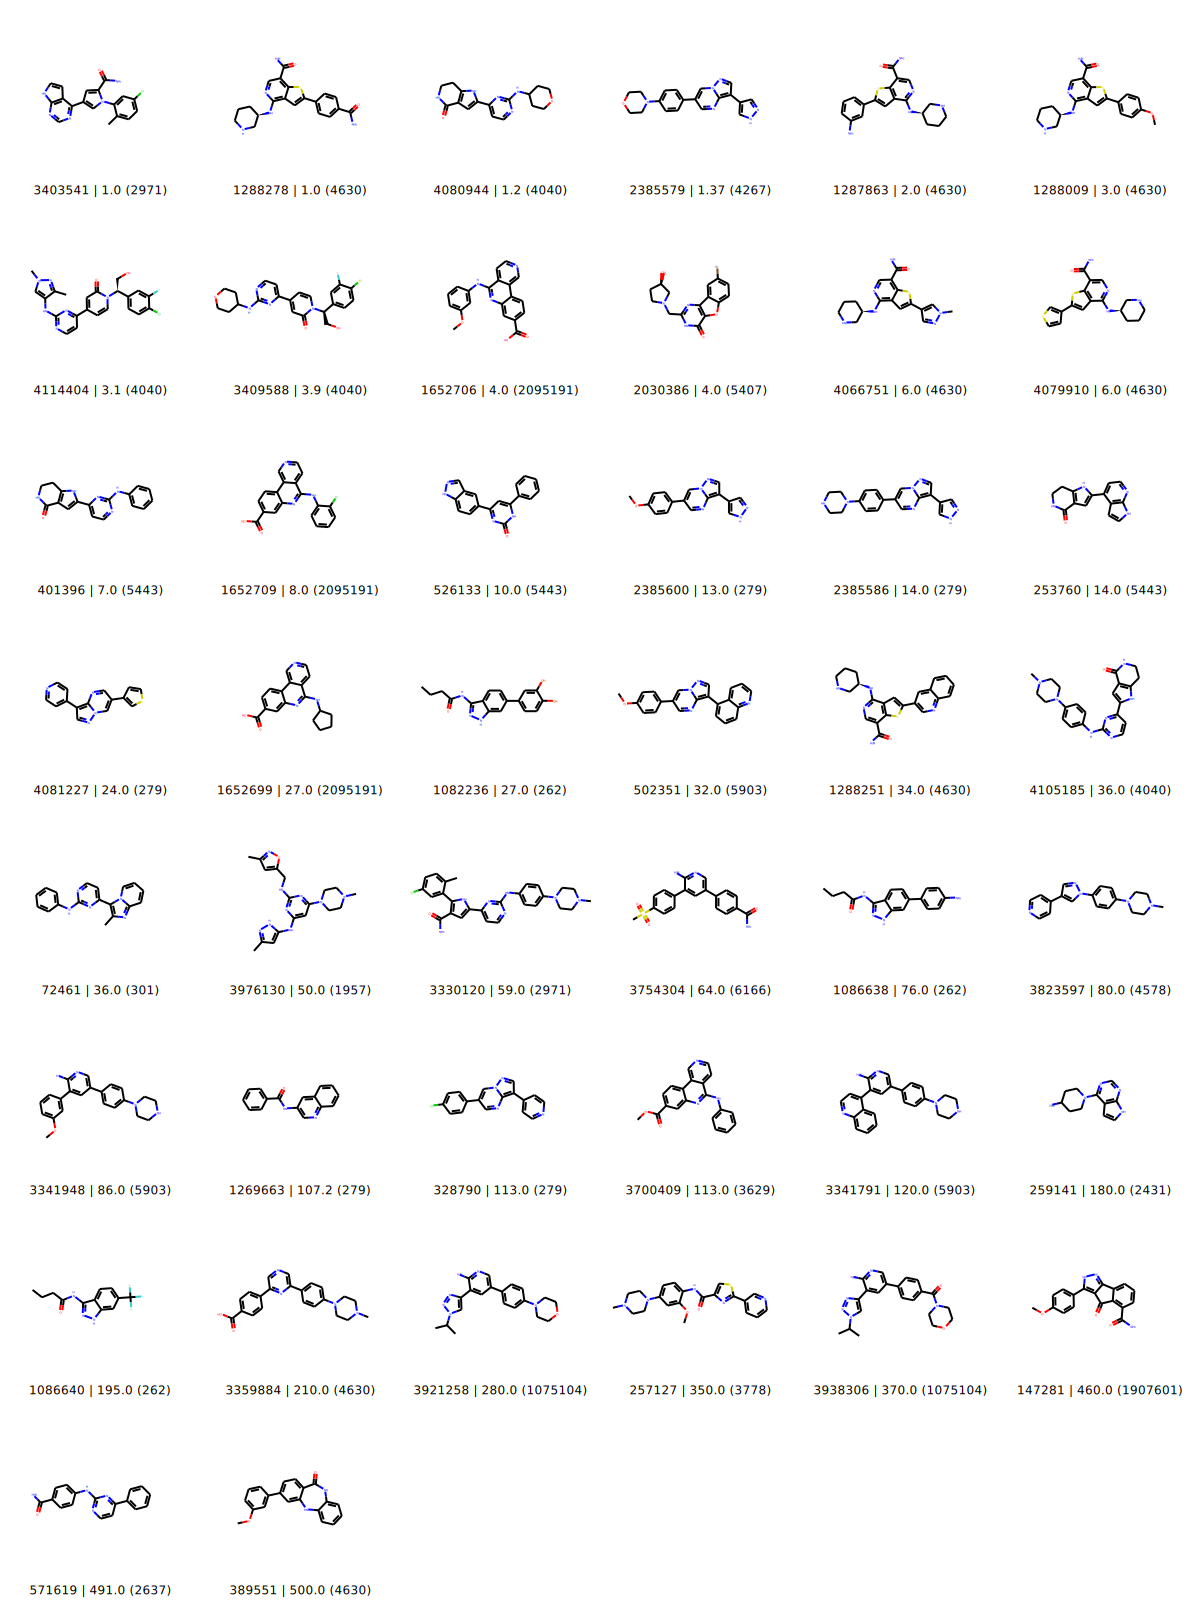

In [73]:
print(f'Molecule ChEMBL ID (add "CHEMBL" at front) | minimum activity value (target ChEMBL ID of tested target (add "CHEMBL" at front))')

image = Draw.MolsToGridImage(
    mols=molecules_with_kinase_targets.smiles.apply(lambda x: Chem.MolFromSmiles(x)).tolist(),
    legends=molecules_with_kinase_targets.apply(
        lambda x: f'{x.molecule_chembl_id[6:]} | {np.min(x.standard_value)} ({x.target_chembl_id[np.argmin(x.standard_value)][6:]})', 
        axis=1
    ).to_list(),
    molsPerRow=6,
    maxMols=100,
    useSVG=True
)
image

Save this figure for publication's supporting information.

In [74]:
molsvg = image.data
molsvg = molsvg.replace('12px', '14px');
with open( f'figures/combinatorial_library_active_kinase_targets.svg', 'w') as f:
    f.write(molsvg)

In [75]:
!inkscape -z -d 300 figures/combinatorial_library_active_kinase_targets.svg -e figures/combinatorial_library_active_kinase_targets.png

DPI: 300
Background RRGGBBAA: ffffff00
Area 0:0:1200:1600 exported to 4000 x 5333 pixels (300 dpi)
Bitmap saved as: figures/combinatorial_library_active_kinase_targets.png


Show activity distribution for molecules with kinase target(s) - plot only minimum activity per molecule (in case there are multiple kinase activities measured).

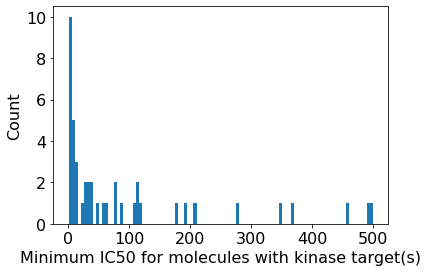

In [76]:
ax = molecules_with_kinase_targets.standard_value.apply(min).plot(kind='hist', bins=100, fontsize=16)
ax.set_xlabel('Minimum IC50 for molecules with kinase target(s)', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.get_figure().savefig('figures/combinatorial_library_active_kinase_targets_activities.png', bbox_inches='tight', transparent=True)

Text(0.5, 0, 'Number of targets per molecule')

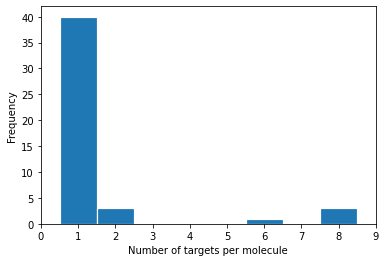

In [77]:
ax = n_active_targets_per_molecule.plot(
    kind='hist', 
    bins=np.arange(n_active_targets_per_molecule.max() + 2) - 0.5, 
    edgecolor='white', 
    linewidth=1.2,
    xlim=[0, n_active_targets_per_molecule.max() + 1]
)
ax.set_xlabel('Number of targets per molecule')

#### Molecules with kinase target(s) with activity of <= 5 nM

In [78]:
activities_active_kinases_5nm = activities_active_kinases[
    activities_active_kinases.standard_value <= 5
]

In [79]:
print(f'Number of molecules with kinase target(s) and an activity of <= 5 nM: {activities_active_kinases_5nm.groupby("molecule_chembl_id").first().shape[0]}')

Number of molecules with kinase target(s) and an activity of <= 5 nM: 10


In [80]:
filtering = add_filtering_step(filtering, activities_active_kinases_5nm, 'Only molecule-kinase pairs with activity <= 5 nM')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,99,77,122,207
1,Remove non-nM activities,99,77,122,207
2,Only human entries,87,66,106,179
3,Get minimum IC50 per molecule-target pair,87,66,90,151
4,"Only ""active"" molecule-target pairs",47,32,45,76
5,Only molecule-kinase pairs,44,30,43,73
6,Only molecule-kinase pairs with activity <= 5 nM,10,9,11,13


#### Write molecules with active kinases (IC50 <= 5nm) to `csv` file

In [81]:
activities_active_kinases_5nm_paper = activities_active_kinases_5nm[['molecule_chembl_id', 'target_pref_name', 'l4', 'assay_chembl_id', 'standard_value']].copy()
activities_active_kinases_5nm_paper['l4'] = activities_active_kinases_5nm_paper.apply(lambda x: x.l4.split()[0], axis=1)
activities_active_kinases_5nm_paper.sort_values(['molecule_chembl_id', 'standard_value'], inplace=True)
activities_active_kinases_5nm_paper = activities_active_kinases_5nm_paper.rename(
    columns={
        'molecule_chembl_id': 'Molecule ChEMBL ID', 
        'target_pref_name': 'Kinase name', 
        'l4': 'Kinase group', 
        'assay_chembl_id': 'Assay ChEMBL ID',
        'standard_value': 'IC50 [nM]'
    }
)
activities_active_kinases_5nm_paper.to_csv('../data/combinatorial_library/combinatorial_library_active_kinase_targets_nm.csv', index=None)